In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
train_data = 'dataset' # name of folder where training data is stored.
# Note - Dataset contains less pictures so to cover the size, 
# We used Data Augmentation to increase the size of dataset.

In [3]:
img_height, img_width = 400, 400  # Use the pixel size of your images
batch_size = 32
num_classes = 3 # 3 characters 

In [4]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2 
)
# rescale -> Normalizes pixel values from (0,255) range to (0,1)
# Validation data split 0.2 which is 20% of data.

In [5]:
train_generator = train_datagen.flow_from_directory(
    train_data,
    target_size=(img_height, img_width), # All images are resized to specified dimensions
    batch_size=batch_size, 
    class_mode='categorical', # For multi-class classification
    subset='training'
)
#flow_from_directory reads the images from the directory . It assumes the directory contains subdirectories,
# where each subdirectory name corresponds to a class label , as we kept in 'train_data' -> dataset
#Spliting data into train_data and validation data

Found 276 images belonging to 3 classes.


In [6]:
validation_generator = train_datagen.flow_from_directory(
    train_data,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)
# Same as Train_generator

Found 68 images belonging to 3 classes.


In [7]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')  
]) # Model 

In [8]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy']) 

In [9]:
epochs = 10 
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)

Epoch 1/10
8/8 [==============================] - 59s 7s/step - loss: 6.1298 - accuracy: 0.3443 - val_loss: 1.4721 - val_accuracy: 0.3594
Epoch 2/10
8/8 [==============================] - 45s 6s/step - loss: 1.0084 - accuracy: 0.5246 - val_loss: 0.8117 - val_accuracy: 0.6250
Epoch 3/10
8/8 [==============================] - 44s 6s/step - loss: 0.4681 - accuracy: 0.8164 - val_loss: 0.5194 - val_accuracy: 0.7812
Epoch 4/10
8/8 [==============================] - 48s 6s/step - loss: 0.2484 - accuracy: 0.9141 - val_loss: 0.2819 - val_accuracy: 0.9219
Epoch 5/10
8/8 [==============================] - 41s 5s/step - loss: 0.1255 - accuracy: 0.9590 - val_loss: 0.1566 - val_accuracy: 0.8906
Epoch 6/10
8/8 [==============================] - 46s 6s/step - loss: 0.0578 - accuracy: 0.9713 - val_loss: 0.1738 - val_accuracy: 0.9062
Epoch 7/10
8/8 [==============================] - 44s 5s/step - loss: 0.0261 - accuracy: 0.9961 - val_loss: 0.4491 - val_accuracy: 0.7812
Epoch 8/10
8/8 [==================

In [10]:
# Final Evaluation 
test_loss, test_accuracy = model.evaluate(validation_generator)
print(f"Validation Accuracy: {test_accuracy}")

3/3 [==============================] - 3s 645ms/step - loss: 0.0765 - accuracy: 1.0000
Validation Accuracy: 1.0


In [11]:
model.save('character_identify_model.h5') # Model Save

C:\Users\Divyank\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [12]:
train_generator.class_indices.items()

dict_items([('Minun', 0), ('Pikachu', 1), ('Plusle', 2)])

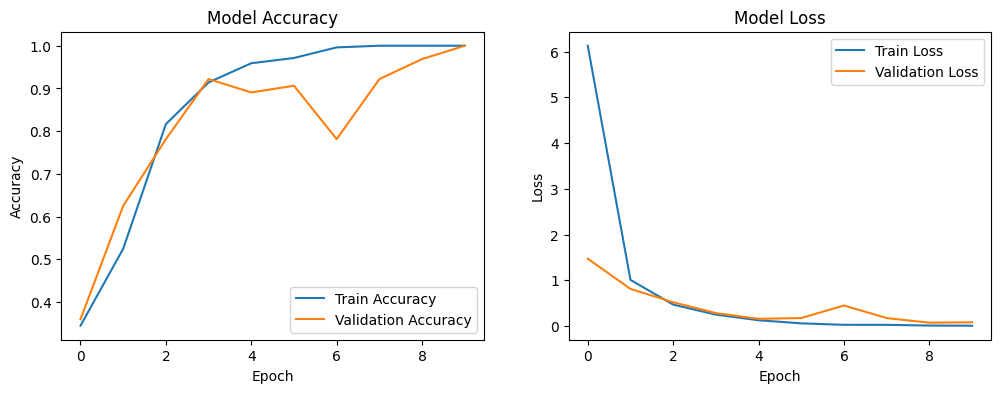

In [13]:
# Plotting the loss and accuracy for every epochs
def plot_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    
    plt.show()

plot_history(history)

In [14]:
# 1. Get true labels and predictions
val_steps = validation_generator.samples // batch_size + 1 # Include all samples
Y_pred = model.predict(validation_generator, steps=val_steps)
y_pred_classes = np.argmax(Y_pred, axis=1) # Predicted classes

# Get true labels for all validation data
y_true = validation_generator.classes[:validation_generator.samples]

# 2. Get the index mapping from the generator (e.g., {'class_A': 0, 'class_B': 1, ...})
class_labels = list(validation_generator.class_indices.keys())

# 3. Create Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
print("\nConfusion Matrix:")
# Display as a DataFrame for better readability
conf_df = pd.DataFrame(conf_matrix, index=class_labels, columns=class_labels)
print(conf_df)

3/3 [==============================] - 3s 642ms/step

Confusion Matrix:
         Minun  Pikachu  Plusle
Minun        9        8       7
Pikachu      7       10       7
Plusle       8        6       6


In [15]:
# Generate Classification Report
report = classification_report(y_true, y_pred_classes, target_names=class_labels)
print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

       Minun       0.38      0.38      0.38        24
     Pikachu       0.42      0.42      0.42        24
      Plusle       0.30      0.30      0.30        20

    accuracy                           0.37        68
   macro avg       0.36      0.36      0.36        68
weighted avg       0.37      0.37      0.37        68



In [16]:
# Converting single img to (0,1) of same size and dim and predicting its class
def predict_image(model_path, image_path, target_size):
    loaded_model = tf.keras.models.load_model(model_path) #loading the trained model
    img = load_img(image_path, target_size=target_size) #using load_img keras fn
    img_array = img_to_array(img) # pixels to array
    img_array = np.expand_dims(img_array, axis=0)  # Adding batch dimension
    img_array /= 255.0  # Normalizing the image (0,1)

    predictions = loaded_model.predict(img_array) # Adding normalize img to predict fn
    predicted_class_index = np.argmax(predictions) 

    class_labels = {v: k for k, v in train_generator.class_indices.items()} # Mapping from class indices to labels
    
    print(predictions) 
    print(predicted_class_index)
    print(class_labels)
    predicted_class_label = class_labels[predicted_class_index]
    return predicted_class_label

In [17]:
# Single Image prediction
model_path = 'character_identify_model.h5'  # Path of saved model
single_image_path = 'test_images\image.png'  # Path to the image you want to predict

In [18]:
predicted_class = predict_image(model_path, single_image_path, (img_height, img_width)) #calling fn
print(f"Predicted class for the image is '{predicted_class}'")

1/1 [==============================] - 0s 175ms/step
[[1.7381291e-07 9.9997544e-01 2.4400742e-05]]
1
{0: 'Minun', 1: 'Pikachu', 2: 'Plusle'}
Predicted class for the image is 'Pikachu'
